In [1]:
# !pip install -q andi-datasets 
!pip install -q stochastic
# !pip install -q tensorflow==2.8.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.6 MB/s eta 0:00:00


# HurstEE: Differentiable Neural Network Layer for Estimating Hurst and Anomalous Diffusion Exponents 

We introduce an implementation of the Time-Averaged Mean Squared Displacement (TA-MSD) method, equivalent to the 2nd-order Generalized Hurst Exponent (GHE) method, as a non-trainable, differentiable layer in TensorFlow and PyTorch frameworks. Our proposed layer effectively addresses the core challenges identified in the 2nd AnDi Challenge, including trajectory heterogeneity and short trajectory segments. The layer also seamlessly handles missing (NaN) values, facilitating integration into complex neural network architectures designed for analyzing heterogeneous trajectories. The proposed differentiable Hurst exponent estimation layer offers simplicity in deployment, eliminating the need for training and reducing computational overhead.

# HurstEE with TensorFlow

In [2]:
import numpy as np
import tensorflow as tf

class HurstEE(tf.keras.layers.Layer):
    def __init__(self, use_correction=False, trim_percent=0, **kwargs):
        """
        Initialization of the HurstEE layer.

        Args:
            use_correction (bool): Whether to apply TEA-MSD&variance correction. Default is False.
            trim_percent (int): Percentage of highest values to trim. Default is 0. DOI 10.1088/2515-7647/adc04e
        """
        super(HurstEE, self).__init__(**kwargs)
        self.use_correction = use_correction
        self.trim_percent = trim_percent

    @staticmethod
    def nanmean(tensor, axis=None, keepdims=False):
        """
        Analog of np.nanmean, ignoring NaN values.

        Args:
            tensor (tf.Tensor): Input tensor.
            axis (int or tuple, optional): Axis or axes along which to compute the mean.
            keepdims (bool, optional): If True, retains reduced dimensions.

        Returns:
            tf.Tensor: Mean value with NaNs ignored.
        """
        mask = ~tf.math.is_nan(tensor)
        masked_tensor = tf.where(mask, tensor, tf.zeros_like(tensor))
        count = tf.reduce_sum(tf.cast(mask, tf.float32), axis=axis, keepdims=keepdims)
        sum_ = tf.reduce_sum(masked_tensor, axis=axis, keepdims=keepdims)
        return sum_ / (count + 1e-8)

    @staticmethod
    def nanstd(tensor, axis=None, keepdims=False):
        """
        Analog of np.nanstd, ignoring NaN values.

        Args:
            tensor (tf.Tensor): Input tensor.
            axis (int or tuple, optional): Axis or axes along which to compute the standard deviation.
            keepdims (bool, optional): If True, retains reduced dimensions.

        Returns:
            tf.Tensor: Standard deviation with NaNs ignored.
        """
        mean_ = HurstEE.nanmean(tensor, axis=axis, keepdims=True)
        sq_diff = tf.square(tensor - mean_)
        var_ = HurstEE.nanmean(sq_diff, axis=axis, keepdims=keepdims)
        return tf.sqrt(var_ + 1e-8)

    @staticmethod
    def trim_array1s(arr, percent):
        """
        Removes a given percentage of the largest values from each row of a 2D tensor, ignoring NaNs.
        
        Args:
            arr (tf.Tensor): Input 2D tensor.
            percent (float): Percentage of values to remove (0 <= percent < 100).

        Returns:
            tf.Tensor: Tensor with values above the threshold replaced by NaN.
        """
        def trim_row(row):
            valid = ~tf.math.is_nan(row)
            valid_values = tf.boolean_mask(row, valid)
            n_valid = tf.shape(valid_values)[0]
            
            def no_valid():
                return row
            
            def do_trim():
                k_float = tf.cast(n_valid, tf.float32) * (percent / 100.0)
                k = tf.cast(tf.round(k_float), tf.int32)
                
                def no_trim():
                    return row
                
                def trim_values():
                    # Sort valid (non-NaN) values in ascending order
                    sorted_valid = tf.sort(valid_values, direction='ASCENDING')
                    # Threshold is the k-th largest value
                    threshold = sorted_valid[-k]
                    # Keep values below threshold, replace others with NaN
                    return tf.where(row < threshold, row, tf.constant(np.nan, dtype=row.dtype))
                
                return tf.cond(tf.equal(k, 0), no_trim, trim_values)
            
            return tf.cond(tf.equal(n_valid, 0), no_valid, do_trim)
        
        return tf.map_fn(trim_row, arr)

    @staticmethod
    def trim_array1s_tea(arr, percent):
        """
        Removes a given percentage of the largest values from the entire tensor, ignoring NaNs.
        The number of elements to remove is based on all non-NaN values.

        Args:
            arr (tf.Tensor): Input tensor.
            percent (float): Percentage of values to remove (0 <= percent < 100).

        Returns:
            tf.Tensor: Tensor with values above the threshold replaced by NaN.
        """
        valid = ~tf.math.is_nan(arr)
        valid_values = tf.boolean_mask(arr, valid)
        n_valid = tf.shape(valid_values)[0]
        
        def no_valid():
            return arr
        
        def do_trim():
            k_float = tf.cast(n_valid, tf.float32) * (percent / 100.0)
            k = tf.cast(tf.round(k_float), tf.int32)
            
            def no_trim():
                return arr
            
            def trim_values():
                sorted_valid = tf.sort(valid_values, direction='ASCENDING')
                threshold = sorted_valid[-k]
                return tf.where(arr < threshold, arr, tf.constant(np.nan, dtype=arr.dtype))
            
            return tf.cond(tf.equal(k, 0), no_trim, trim_values)
        
        return tf.cond(tf.equal(n_valid, 0), no_valid, do_trim)

    def tf_normalize_distribution(self, arr, target_mean, T):
        """
        Normalize the distribution with correction.

        Args:
            arr (tf.Tensor): Input array.
            target_mean (tf.Tensor): Target mean value.
            T (tf.Tensor): Effective time/count indicator.

        Returns:
            tf.Tensor: Normalized array.
        """
        current_mean = self.nanmean(arr)
        current_std = self.nanstd(arr)
        adjustment_term = tf.maximum(current_std**2 - 0.92 / T, 0)**0.5
        standardized = (arr - current_mean) / (current_std + 1e-8)
        return standardized * adjustment_term + target_mean

    def call(self, inputs):
        """
        Forward pass of the layer.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch_size, timesteps, input_channels).

        Returns:
            tf.Tensor: Estimated alpha values.
        """
        batch_size = tf.shape(inputs)[0]
        timesteps = tf.shape(inputs)[1]
        input_channels = tf.shape(inputs)[2]

        # Count non-NaN elements across the batch
        not_nan_mask = ~tf.math.is_nan(inputs)
        not_nan_count = tf.reduce_sum(tf.cast(not_nan_mask, tf.float32))

        epsilon = 1e-14
        x_all = inputs
        max_lag = 4
        msds = []
        teamsd_list = []

        # --- Compute MSD and TEA-MSD ---
        for lag in range(1, max_lag + 1):
            displacements = x_all[:, lag:, :] - x_all[:, :-lag, :]
            squared_displacements = tf.square(displacements)
            squared_displacements_sum = tf.reduce_sum(squared_displacements, axis=2)

            # For MSD – trim each row
            msd = self.nanmean(
                self.trim_array1s(squared_displacements_sum, self.trim_percent),
                axis=1
            )
            msds.append(msd)

            # For TEA-MSD – trim the array as a whole
            teamsd_lag = self.nanmean(
                self.trim_array1s_tea(squared_displacements_sum, self.trim_percent)
            )
            teamsd_list.append(teamsd_lag)

        msds = tf.stack(msds, axis=1)             # (batch_size, max_lag)
        teamsd = tf.stack(teamsd_list, axis=0)    # (max_lag,)

        t_lags = tf.range(1, max_lag + 1, dtype=tf.float32)
        log_t_lags = tf.math.log(t_lags + epsilon)

        # --- Compute TEA-MSD alpha ---
        log_teamsd = tf.math.log(teamsd + epsilon)
        mean_x = self.nanmean(log_t_lags)
        mean_x2 = self.nanmean(tf.square(log_t_lags))
        mean_y_teamsd = self.nanmean(log_teamsd)
        mean_xy_teamsd = self.nanmean(log_t_lags * log_teamsd)

        numerator_teamsd = mean_xy_teamsd - mean_x * mean_y_teamsd
        denominator = mean_x2 - mean_x**2
        alpha_teamsd = numerator_teamsd / denominator

        # --- Compute alpha for the batch ---
        log_msds = tf.math.log(msds + epsilon)   # (batch_size, max_lag)
        mean_y = self.nanmean(log_msds, axis=1)  # (batch_size,)
        mean_xy = self.nanmean(log_t_lags * log_msds, axis=1)
        numerator = mean_xy - mean_x * mean_y
        alpha = numerator / denominator          # (batch_size,)

        # --- Replace alpha with NaN if the last MSD < 1e-6 ---
        last_msd = msds[:, -1]  # (batch_size,)
        mask_nan = last_msd < 1e-6
        alpha = tf.where(mask_nan, tf.fill(tf.shape(alpha), np.nan), alpha)

        # --- Compute T based on the number of valid trajectories ---
        valid_mask = ~mask_nan
        valid_count = tf.reduce_sum(tf.cast(valid_mask, tf.float32))
        T = not_nan_count / (valid_count * tf.cast(input_channels, tf.float32))

        # --- Apply normalization correction if enabled ---
        if self.use_correction:
            alpha = self.tf_normalize_distribution(alpha, alpha_teamsd, T)

        # --- Clip alpha to the valid range ---
        H = tf.clip_by_value(alpha, clip_value_min=0.0001, clip_value_max=1.999) / 2

        return H

2025-06-07 11:24:46.672763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749295486.948726      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749295487.029314      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# HurstEE with PyTorch

In [3]:
import torch
import torch.nn as nn
import numpy as np

class PyHurstEE(nn.Module):
    def __init__(self, use_correction=False, trim_percent=0):
        super(PyHurstEE, self).__init__()
        self.use_correction = use_correction
        self.trim_percent = trim_percent

    @staticmethod
    def nanmean(tensor, dim=None, keepdim=False, eps=1e-8):
        mask = ~torch.isnan(tensor)
        masked = torch.where(mask, tensor, torch.zeros_like(tensor))
        count = mask.sum(dim=dim, keepdim=keepdim).to(tensor.dtype)
        sum_ = masked.sum(dim=dim, keepdim=keepdim)
        return sum_ / (count + eps)

    @staticmethod
    def nanstd(tensor, dim=None, keepdim=False, eps=1e-8):
        mean_ = PyHurstEE.nanmean(tensor, dim=dim, keepdim=True, eps=eps)
        sq_diff = (tensor - mean_)**2
        var = PyHurstEE.nanmean(sq_diff, dim=dim, keepdim=keepdim, eps=eps)
        return torch.sqrt(var + eps)

    @staticmethod
    def trim_array1s(arr, percent):
        rows = []
        for row in arr:
            valid = ~torch.isnan(row)
            vals = row[valid]
            n = vals.numel()
            if n == 0:
                rows.append(row)
                continue
            k = int(round(n * percent / 100.0))
            if k == 0:
                rows.append(row)
                continue
            sorted_vals, _ = torch.sort(vals)
            threshold = sorted_vals[-k]
            trimmed = torch.where(row < threshold, row, torch.tensor(np.nan, device=row.device, dtype=row.dtype))
            rows.append(trimmed)
        return torch.stack(rows, dim=0)

    @staticmethod
    def trim_array1s_tea(arr, percent):
        valid = ~torch.isnan(arr)
        vals = arr[valid]
        n = vals.numel()
        if n == 0:
            return arr
        k = int(round(n * percent / 100.0))
        if k == 0:
            return arr
        sorted_vals, _ = torch.sort(vals)
        threshold = sorted_vals[-k]
        return torch.where(arr < threshold, arr, torch.tensor(np.nan, device=arr.device, dtype=arr.dtype))

    def normalize_distribution(self, arr, target_mean, T, eps=1e-8):
        current_mean = self.nanmean(arr)
        current_std = self.nanstd(arr)
        adjustment = torch.sqrt(torch.clamp(current_std**2 - 0.92 / T, min=0.0))
        standardized = (arr - current_mean) / (current_std + eps)
        return standardized * adjustment + target_mean

    def forward(self, inputs):
        if isinstance(inputs, np.ndarray):
            inputs = torch.from_numpy(inputs).float()
        batch, timesteps, channels = inputs.shape
        not_nan = ~torch.isnan(inputs)
        not_nan_count = not_nan.sum().to(inputs.dtype)

        max_lag = 4
        msds = []
        teamsd_list = []

        for lag in range(1, max_lag + 1):
            disp = inputs[:, lag:, :] - inputs[:, :-lag, :]
            sq = disp**2
            sq_sum = sq.sum(dim=2)

            trimmed = PyHurstEE.trim_array1s(sq_sum, self.trim_percent)
            msd = PyHurstEE.nanmean(trimmed, dim=1)
            msds.append(msd)

            teamsd_arr = PyHurstEE.trim_array1s_tea(sq_sum, self.trim_percent)
            teamsd_lag = PyHurstEE.nanmean(teamsd_arr)
            teamsd_list.append(teamsd_lag)

        msds = torch.stack(msds, dim=1)
        teamsd = torch.stack(teamsd_list)

        eps = 1e-14
        t_lags = torch.arange(1, max_lag+1, dtype=inputs.dtype, device=inputs.device)
        log_t = torch.log(t_lags + eps)

        log_teamsd = torch.log(teamsd + eps)
        mean_x = PyHurstEE.nanmean(log_t)
        mean_x2 = PyHurstEE.nanmean(log_t**2)
        mean_y_tea = PyHurstEE.nanmean(log_teamsd)
        mean_xy_tea = PyHurstEE.nanmean(log_t * log_teamsd)
        num_tea = mean_xy_tea - mean_x * mean_y_tea
        den = mean_x2 - mean_x**2
        alpha_tea = num_tea / den

        log_msds = torch.log(msds + eps)
        mean_y = PyHurstEE.nanmean(log_msds, dim=1)
        mean_xy = PyHurstEE.nanmean(log_t * log_msds, dim=1)
        num = mean_xy - mean_x * mean_y
        alpha = num / den

        last = msds[:, -1]
        mask = last < 1e-6
        alpha = alpha.masked_fill(mask, float('nan'))

        valid = ~mask
        valid_count = valid.sum().to(inputs.dtype)
        T = not_nan_count / (valid_count * channels)

        if self.use_correction:
            alpha = self.normalize_distribution(alpha, alpha_tea, T)

        H = torch.clamp(alpha, min=0.0001, max=1.999) / 2
        return H


In [4]:

import numpy as np
from sklearn.metrics import mean_absolute_error


## RANDI weights

In [5]:
class ta_msd():
    def __init__(self):
        ''' Contains mean squared displacement (MSD) based methods to analyze trajectories.  '''
        
    def trim_array1s(self, arr, percent=0):
        """
        Removes the specified percentage of the largest values from each row of the array, ignoring NaN.
        
        Parameters:
        arr (numpy.ndarray): Input data array.
        percent (float): Percentage of the largest values to remove from each row (0 <= percent < 100).
        
        Returns:
        numpy.ndarray: Array with the largest values removed from each row.
        """
        if not (0 <= percent < 100):
            raise ValueError("The 'percent' parameter must be in the range [0, 100).")
        
        if not isinstance(arr, np.ndarray):
            raise TypeError("Input data must be a numpy array.")
        
        if len(arr) == 0:
            return np.array([])  # Return an empty array if input array is empty
        
        result = np.empty_like(arr, dtype=float)
        
        for i, row in enumerate(arr):
            # Select only non-NaN values from the row
            non_nan_values = row[~np.isnan(row)]
            
            if len(non_nan_values) == 0:
                # If all values in the row are NaN, leave it unchanged
                result[i] = row
                continue
            
            # Sort non-NaN values in ascending order
            sorted_values = np.sort(non_nan_values)
            
            # Calculate the number of elements to remove
            n_non_nan = len(sorted_values)
            k = int(np.ceil(percent / 100 * n_non_nan))  # Number of elements to remove
            
            if k == 0:
                # If there are no elements to remove, copy the row unchanged
                result[i] = row
                continue
            
            # Determine the threshold value for removal
            threshold = sorted_values[-k]
            
            # Create a mask to filter values in the current row
            mask = row <= threshold
            result[i] = np.where(mask, row, np.nan)  # Replace values above the threshold with NaN
        
        return result
    
    def trim_array1s_tea(self, arr, percent=0):
        """
        Removes the specified percentage of the largest values from the entire array, ignoring NaN.
        The number of elements to remove is calculated based on non-NaN values.
        The order of values in each row is preserved.
    
        Parameters:
        arr (numpy.ndarray): Input data array.
        percent (float): Percentage of the largest values to remove (0 <= percent < 100).
    
        Returns:
        numpy.ndarray: Array with the largest values removed.
        """
        if not (0 <= percent < 100):
            raise ValueError("The 'percent' parameter must be in the range [0, 100).")
        
        if not isinstance(arr, np.ndarray):
            raise TypeError("Input data must be a numpy array.")
        
        if len(arr) == 0:
            return np.array([])  # Return an empty array if input array is empty
        
        # Flatten the array to one dimension, ignoring NaN
        flattened = arr[~np.isnan(arr)]
        
        if len(flattened) == 0:
            return arr  # If all values are NaN, return the original array
        
        # Sort the array without NaN
        sorted_values = np.sort(flattened)
        
        # Calculate the number of elements to remove based on non-NaN values
        n_non_nan = len(sorted_values)
        k = int(np.ceil(percent / 100 * n_non_nan))  # Number of elements to remove
        
        if k == 0:
            return arr  # If there are no elements to remove, return the original array
        
        # Determine the threshold value for removal
        threshold = sorted_values[-k] if k > 0 else -np.inf
        
        # Create a mask to filter values
        mask = arr <= threshold
        result = np.where(mask, arr, np.nan)  # Replace values above the threshold with NaN
        
        return result    


    def tamsd(self, 
              trajs:np.ndarray, 
              t_lags:np.ndarray,
              method='MSD'
             ):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        trajs : np.array
            Set of trajectories of dimenions NxDxT (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        dim : int
            Dimension of the trajectories (currently only 1 and 2 supported)
        
        Returns       
        -------
        np.array
            TA-MSD of each trayectory / t_lag
            
        '''
        tamsd = np.zeros((trajs.shape[0],len(t_lags)), dtype= float)
        for idx, tlag in enumerate(t_lags):
            res1 = np.nanmean(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), axis=-1)
            res4 = np.nanmedian(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), axis=-1)
            res5 = np.nanquantile(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 0.632, axis=-1)
         
            res3 = np.nanmean(self.trim_array1s(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 15), axis=-1) * 1.664

            if method=='MSD':
                    tamsd[:,idx] = res1
            elif method=='MSDt':
                    tamsd[:,idx] = res3
            elif method=='MedianSD':
                    tamsd[:,idx] = res4            
            elif method=='QSD':
                    tamsd[:,idx] = res5     

        return tamsd
        
    def teamsd(self, 
              trajs:np.ndarray, 
              t_lags:np.ndarray,
              method='MSD'
             ):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        trajs : np.array
            Set of trajectories of dimenions NxDxT (N: number of trajectories, D: dimension, T: lenght)
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        dim : int
            Dimension of the trajectories (currently only 1 and 2 supported)
        
        Returns       
        -------
        np.array
            TA-MSD of each trayectory / t_lag
            
        '''
        teamsd = np.zeros((1,len(t_lags)), dtype= float)
        for idx, tlag in enumerate(t_lags):
            res1 = np.nanmean(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1))
            res4 = np.nanmedian(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1))
            res5 = np.nanquantile(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 0.632)
         
            res3 = np.nanmean(self.trim_array1s_tea(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 15)) * 1.664

            if method=='MSD':
                    teamsd[:,idx] = res1
            elif method=='MSDt':
                    teamsd[:,idx] = res3
            elif method=='MedianSD':
                    teamsd[:,idx] = res4            
            elif method=='QSD':
                    teamsd[:,idx] = res5 
        return teamsd    

    def get_diff_coeff(self, 
                       trajs:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        if not t_lags:
            t_lags = np.arange(1, 5)

        tasmd = self.tamsd(trajs, t_lags) 

        res = np.zeros(trajs.shape[0], dtype= float) 
        for idx, row in enumerate(tasmd):
            if not np.any(np.isnan(row)):
                res[idx] = np.polyfit(t_lags, row, deg = 1)[0] / 4
                # print(idx, np.log(row))
            else:
                res[idx] = np.NaN
                # print('-')
        return res
    
    def get_tea_diff_coeff(self, 
                       trajs:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        if not t_lags:
            t_lags = np.arange(1, 5)

        teasmd = self.teamsd(trajs, t_lags) 



        if not np.any(np.isnan(teasmd)):
            res = np.polyfit(t_lags, teasmd[0], deg = 1)[0] / 4
            # print(idx, np.log(row))
        else:
            res = np.NaN
            # print('-')
        return res
        
    def get_exponent(self, 
                     trajs:np.ndarray, 
                     t_lags:list = None, method='MSD'):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
            
            
        if not t_lags:
            t_lags = np.arange(1, 5)

        tasmd = self.tamsd(trajs, t_lags, method)

        res = np.zeros(trajs.shape[0], dtype= float) 
        for idx, row in enumerate(tasmd):
            if not np.any(np.isnan(row)):
                res[idx] = np.polyfit(np.log(t_lags), np.log(row), deg = 1)[0]
                # print(idx, np.log(row))
            else:
                res[idx] = np.NaN
                # print('-')
        return res       

    def get_tea_exponent(self, 
                     trajs:np.ndarray, 
                     t_lags:list = None, method='MSD'):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
            
            
        if not t_lags:
            t_lags = np.arange(1, 5)

        teasmd = self.teamsd(trajs, t_lags, method)



        if not np.any(np.isnan(teasmd)):
            res = np.clip(np.polyfit(np.log(t_lags), np.log(teasmd[0]), deg = 1)[0], 0.001, 1.999)
            # print(idx, np.log(row))
        else:
            res = np.NaN
            # print('-')
        return res

In [6]:
"""
Created on Wes June 21 16:44:17 2023

@author: zqfeng
"""

import sys
import numpy as np
import scipy.optimize as op


class AddMethods(object):

    def __init__(self):
        None

    def Divisors(self, N: int, minimal=20) -> list:
        D = []
        for i in range(minimal, N // minimal + 1):
            if N % i == 0:
                D.append(i)
        return D

    def findOptN(self, N: int, minimal=20) -> int:
        """
        Find such a natural number OptN that possesses the largest number of
        divisors among all natural numbers in the interval [0.99*N, N]
        """
        N0 = int(0.99 * N)
        # The best length is the one which have more divisiors
        Dcount = [len(self.Divisors(i, minimal)) for i in range(N0, N + 1)]
        OptN = N0 + Dcount.index(max(Dcount))
        return OptN

    def OLE_linprog(self, A: np.ndarray, b: np.ndarray) -> np.ndarray:
        '''
        Ax = b (Given A & b, try to derive x)

        Parameters
        ----------
        A : matrix like. With shape m x n.
        b : array like. With shape n x 1.

        Returns
        -------
        x : Minimal L1 norm solution of the system of equations.

        Reference
        ---------
        YAO Jian-kang. An Algorithm for Minimizing l1-Norm to Overdetermined
        Linear Eguations[J]. JIANGXI SCE7NICE, 2007, 25(1): 1-4.
        (Available at:
        http://d.g.wanfangdata.com.cn/Periodical_jxkx200701002.aspx)

        Version: 1.0 writen by z.q.feng @2022.03.13
        '''
        A, b = np.array(A), np.array(b)
        if np.size(A, 0) < np.size(A, 1):
            raise ValueError('Matrix A rows must greater than columns!')
        m, n = A.shape
        # Trans A into two matrix(n x n and (m - n) x n)
        A1, A2 = A[:n, :], A[n:, :]
        if np.linalg.matrix_rank(A) >= n:
            # inverse of A1
            A1_ = np.linalg.pinv(A1)
        else:
            # Generalized inverse of A1
            A1_ = np.linalg.pinv(A1)
        # c_ij = A2 * A1_
        c = np.dot(A2, A1_)
        # r(n+1:m) = A2*inv(A1)*r(1:n) + d
        d = np.dot(c, b[:n]) - b[n:]
        # Basic-Pursuit, target function = sum(u, v)
        t = np.ones([2 * m, 1])
        # Aeq_ = [c I(m-n)]
        Aeq_ = np.hstack([-c, np.eye(m - n, m - n)])
        # Aeq[u v] = Aeq_ * (u - v)
        Aeq = np.hstack([Aeq_, -Aeq_])
        # u, v > 0
        bounds = [(0, None) for i in range(2 * m)]
        # r0 = [u; v]
        r0 = op.linprog(t, A_eq=Aeq, b_eq=d, bounds=bounds,
                        method='revised simplex')['x']
        # Minimal L1-norm residual vector, r = u - v
        r = np.array([r0[:m] - r0[m:]])
        # Solving compatible linear equations Ax = b + r
        # Generalized inverse solution
        x = np.linalg.pinv(A).dot(b + r.T)
        return x

    def FixedPointSolver(self, fun, x0, eps=1e-6, **kwargs):
        """
        Solving the fixed points.
        """
        k, k_max = 0, 10000
        x_guess, dist = x0, 1
        while dist > eps and k < k_max:
            x_improved = fun(x_guess, **kwargs)
            dist = abs(x_improved - x_guess)
            x_guess = x_improved
            k += 1
        return x_guess

    def LocalMin(self, fun, interval: list, **kwargs):
        """
            The method used is a combination of  golden  section  search  and
        successive parabolic interpolation.  convergence is never much slower
        than  that  for  a  Fibonacci search.  If fun has a continuous second
        derivative which is positive at the minimum (which is not  at  ax  or
        bx),  then  convergence  is  superlinear, and usually of the order of
        about  1.324....
            The function fun is never evaluated at two points closer together
        than  eps*abs(fmin)+(tol/3), where eps is  approximately  the  square
        root  of  the  relative  machine  precision.   if  fun  is a unimodal
        function and the computed values of  fun  are  always  unimodal  when
        separated  by  at least  eps*abs(x)+(tol/3), then  fmin  approximates
        the abcissa of the global minimum of fun on the interval  ax,bx  with
        an error less than  3*eps*abs(fmin)+tol.  if  fun  is  not  unimodal,
        then fmin may approximate a local, but perhaps non-global, minimum to
        the same accuracy.
            This function subprogram is a slightly modified  version  of  the
        python3 procedure  localmin  given in Ref[1] page79.

        Parameters
        ----------
        fun      : Abcissa approximating the point where fun attains a minimum.
        interval : Iterative interval of target minimum point.

        Returns
        -------
        The Hurst exponent of time series ts.

        References
        ----------
        [1] Richard Brent, Algorithms for Minimization without Derivatives,
            Prentice-Hall, Inc. (1973).

        Written by z.q.feng (2023.06.07).
        """
        a, b = min(interval), max(interval)
        # c is the squared inverse of the golden ratio
        c, d, e = (3 - 5**0.5) / 2, 0, 0
        # eps is approximately the square root of relative machine precision.
        tol = sys.float_info.epsilon**0.25
        eps = tol**2
        # the smallest 1.000... > 1 : tol1 = 1 + eps**2
        v = w = x = a + c * (b - a)
        fv = fw = fx = fun(x, **kwargs)
        # main loop starts here
        while True:
            m = (a + b) / 2
            tol1 = eps * abs(x) + tol / 3
            tol2 = tol1 * 2
            # check stopping criterion
            if abs(x - m) <= tol2 - (b - a) / 2:
                break
            p = q = r = 0
            # fit parabola
            if abs(e) > tol1:
                r = (x - w) * (fx - fv)
                q = (x - v) * (fx - fw)
                p = (x - v) * q - (x - w) * r
                q = (q - r) * 2
                if q > 0:
                    p *= -1
                else:
                    q *= -1
                r, e = e, d
            if abs(p) >= abs(0.5 * q * r) or p <= q * (a-x) or p >= q * (b-x):
                # a golden-section step
                e = (b if x < m else a) - x
                d = c * e
            else:
                # a parabolic-interpolation step
                d = p / q
                u = x + d
                # f must not be evaluated too close to ax or bx
                if u - a < tol2 or b - u < tol2:
                    d = tol1 if x < m else -tol1
            # f must not be evaluated too close to x
            if abs(d) >= tol1:
                u = x + d
            elif d > 0:
                u = x + tol1
            else:
                u = x - tol1
            fu = fun(u, **kwargs)
            # update  a, b, v, w, and x
            if fu <= fx:
                if u < x:
                    b = x
                else:
                    a = x
                v, fv, w, fw, x, fx = w, fw, x, fx, u, fu
            else:
                if u < x:
                    a = u
                else:
                    b = u
                if fu <= fw or w == x:
                    v, fv, w, fw = w, fw, u, fu
                elif fu <= fv or v == x or v == w:
                    v, fv = u, fu
        # end of main loop
        return x

In [7]:
import pywt
import numpy as np
from stochastic.processes.continuous import FractionalBrownianMotion as fbm
from math import pi, gamma
from scipy import fft, stats


class HurstIndexSolver(AddMethods):

    def __init__(self):
        None

    def __FitCurve(self, Scale: list, StatisticModel: list,
                   method='L2') -> float:
        """
        Fitting scale ~ statisticModel in a log-log plot.
        """
        Scale = np.log10(np.array([Scale]))
        Scale = np.vstack([Scale, np.ones(len(StatisticModel))]).T
        if method == 'L2':
            # slope = np.polyfit(np.log10(Cm), np.log10(AM), 1)[0]
            slope, c = np.linalg.lstsq(
                Scale,
                np.log10(StatisticModel),
                rcond=-1
            )[0]
        elif method == 'L1':
            slope, c = super().OLE_linprog(
                Scale,
                np.array([np.log10(StatisticModel)]).T
            )
            slope = slope[0]
        # slope = np.polyfit(np.log(Scale), np.log(StatisticModel), deg = 1)[0]
        return slope

    def EstHurstClustering(self, ts, order: float, minimal=10,
                           method='L2') -> float:
        """
        Calculate the Hurst exponent using Clustering Method.

        Parameters
        ----------
        ts     : Time series.
        minimal: The box sizes that the sample is divided into, default as 10.
        method : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        The Hurst exponent of time series X using
        Absolute Moments Method (AM).

        Reference
        ---------
        Hamza A H, Hmood M Y. Comparison of Hurst exponent estimation methods
        [J]. 2021.

        written by z.q.feng at 2022.09.05
        """
        N = len(ts)
        # make sure m is large and (N / m) is large
        OptN = super().findOptN(N, minimal=minimal)
        M = super().Divisors(OptN, minimal=minimal)

        ts = ts[N - OptN:]
        # The mean for series
        Avg = np.mean(ts)

        CM = []
        for m in M:
            k = OptN // m
            # remove the redundant data at the begin
            # each row is a subseries with N m
            Xsub = np.reshape(ts, [k, m])
            # mean of each suseries
            Xm = np.mean(Xsub, axis=1)
            # order == 1 : Absolute Moments Method
            # order == 2 : Aggregated Variance Method
            CM.append(np.mean(abs(Xm - Avg)**order))

        slope = self.__FitCurve(M, CM, method=method)
        return slope / order + 1

    def EstHurstAbsoluteMoments(self, ts, minimal=20, method='L2') -> float:
        """
        Calculate the Hurst exponent using Cluster Method.

        Parameters
        ----------
        ts     : Time series.
        minimal: The box sizes that the sample is divided into, default as 10.
        method : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        The Hurst exponent of time series X using
        Absolute Moments Method (AM).

        Reference
        ---------
        Hamza A H, Hmood M Y. Comparison of Hurst exponent estimation methods
        [J]. 2021.

        written by z.q.feng at 2022.09.05
        """
        N = len(ts)
        # make sure m is large and (N / m) is large
        OptN = super().findOptN(N, minimal=minimal)
        M = super().Divisors(OptN, minimal=minimal)

        ts = ts[N - OptN:]
        # The mean for series
        Avg = np.mean(ts)

        AM = []
        for m in M:
            k = OptN // m
            # remove the redundant data at the begin
            # each row is a subseries with N m
            Xsub = np.reshape(ts, [k, m])
            # mean of each suseries
            Xm = np.mean(Xsub, axis=1)
            AM.append(np.linalg.norm(Xm - Avg, 1) / len(Xm))

        slope = self.__FitCurve(M, AM, method=method)
        return slope + 1

    def EstHurstAggregateVariance(self, ts, minimal=12, method='L2') -> float:
        """
        Calculate the Hurst exponent using Cluster Method.

        Parameters
        ----------
        ts     : Time series.
        minimal: The box sizes that the sample is divided into, default as 10.
        method : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        The Hurst exponent of time series X using
        Aggregate Variance Method (AV).

        Reference
        ---------
        Hamza A H, Hmood M Y. Comparison of Hurst exponent estimation methods
        [J]. 2021.

        written by z.q.feng at 2022.09.05
        """
        N = len(ts)
        # The mean for series
        # Avg = np.mean(ts)

        # make sure m is large and (N / m) is large
        OptN = super().findOptN(N, minimal=minimal)
        M = super().Divisors(OptN, minimal=minimal)

        AV = []
        for m in M:
            k = OptN // m
            # remove the redundant data at the begin
            # each row is a subseries with N m
            Xsub = np.reshape(ts[N - OptN:], [k, m])
            # mean of each suseries
            Xm = np.mean(Xsub, axis=1)
            AV.append(np.var(Xm, ddof=0))
            # AV.append(np.var(Xm - Avg, ddof=1))

        slope = self.__FitCurve(M, AV, method=method)
        return slope / 2 + 1

    def EstHurstDFAnalysis(self, ts, minimal=12, method='L2') -> float:
        """
        DFA Calculate the Hurst exponent using DFA analysis.

        Parameters
        ----------
        ts     : Time series.
        minimal: The box sizes that the sample is divided into, default as 10.
        method : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        The Hurst exponent of time series X using
        Detrended Fluctuation Analysis (DFA).

        References
        ----------
        [1] C.-K.Peng et al. (1994) Mosaic organization of DNA nucleotides,
        Physical Review E 49(2), 1685-1689.
        [2] R.Weron (2002) Estimating long range dependence: finite sample
        properties and confidence intervals, Physica A 312, 285-299.

        Written by z.q.feng (2022.09.23).
        Based on dfa.m orginally written by afal Weron (2011.09.30).
        """
        DF = []
        N = len(ts) + 1
        y = np.concatenate([[0], np.cumsum(ts)])

        OptN = super().findOptN(len(ts), minimal=minimal)
        M = super().Divisors(OptN, minimal=minimal)

        for m in M:
            k = OptN // m
            Y = np.reshape(y[N - OptN:], [m, k], order='F')
            F = np.copy(Y)
            # t = 1, 2, ..., m
            t = np.linspace(1, m, m)
            for i in range(k):
                p = np.polyfit(t, Y[:, i], 1)
                F[:, i] = Y[:, i] - t * p[0] - p[1]
            DF.append(np.mean(np.std(F)))

        slope = self.__FitCurve(M, DF, method=method)
        return slope

    def __getBox(self, j: int) -> int:
        """
        [2^{(j-1)/4}] for j in (11, 12, 13, ...) if k > 4
        """
        if j < 5:
            return j
        else:
            return int(2 ** ((j + 5) / 4))

    def EstHurstHiguchi(self, ts, minimal=11, method='L2') -> float:
        """
        Calculate the Hurst exponent using Higuchi Method.

        Parameters
        ----------
        ts     : Time series.
        method : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        The Hurst exponent of time series X using Higuchi Method (HM).

        References
        ----------
        [1] Higuchi T. Approach to an irregular time series on the basis of
            the fractal theory[J]. Physica D: Nonlinear Phenomena, 1988, 31(2):
            277-283.
        """
        N = len(ts) + 1
        Lm, Cm = [], []
        # FGN --diff--> Gaussian
        Y = np.concatenate([[0], np.cumsum(ts)])

        for j in range(1, minimal):
            Lk = []
            m = self.__getBox(j)
            Cm.append(m)
            k = N // m
            Xsub = np.reshape(Y[N % m:], [k, m])
            for i in range(1, k):
                Lk.append(abs(Xsub[i] - Xsub[i - 1]))
            # Lm = np.mean(np.array(Lk), axis=0) * (N - 1) / k / k
            Lm.append(np.mean(Lk) * (N - 1) / m / m)

        slope = self.__FitCurve(Cm, Lm, method=method)
        return slope + 2

    def EstHurstRegrResid(self, ts, minimal=20, method='L2') -> float:
        '''
        Variance of the regression residuals (VRR) for Hurst Index.
        '''
        Sigma = []
        N = len(ts)

        OptN = super().findOptN(N, minimal=minimal)
        M = super().Divisors(OptN, minimal=minimal)[:-3]

        for m in M:
            res = []
            k = OptN // m
            t = np.linspace(1, m, m)
            X = np.reshape(ts[N - OptN:], [k, m])
            for i in range(k):
                Y = np.cumsum(X[i] - np.mean(X[i]))
                a, b = np.polyfit(t, Y, 1)
                res.append(np.std(Y - a * t - b, ddof=1))
            Sigma.append(np.mean(res))

        slope = self.__FitCurve(M, Sigma, method=method)
        return slope

    def __HalfSeries(self, s: list, n: int) -> list:
        X = []
        for i in range(0, len(s) - 1, 2):
            X.append((s[i] + s[i + 1]) / 2)
        # if length(s) is odd
        if len(s) % 2 != 0:
            X.append(s[-1])
            n = (n - 1) // 2
        else:
            n = n // 2
        return [np.array(X), n]

    def RS4Hurst(self, ts: np.ndarray, minimal=4, method='L2') -> float:
        """
        RS Analysis for solve the Hurst exponent.
        """
        ts = np.array(ts)
        # N is use for storge the length sequence
        N, RS, n = [], [], len(ts)
        while (True):
            N.append(n)
            # Calculate the average value of the series
            m = np.mean(ts)
            # Construct mean adjustment sequence
            mean_adj = ts - m
            # Construct cumulative deviation sequence
            cumulative_dvi = np.cumsum(mean_adj)
            # Calculate sequence range
            srange = max(cumulative_dvi) - min(cumulative_dvi)
            # Calculate the unbiased standard deviation of this sequence
            unbiased_std_dvi = np.std(ts, ddof=1)
            # Calculate the rescaled range of this sequence
            RS.append(srange / unbiased_std_dvi)
            # While n < 2 then break
            if n < minimal:
                break
            # Rebuild this sequence by half length
            ts, n = self.__HalfSeries(ts, n)
        # Get Hurst-index by fit log(RS)~log(n)
        slope = np.polyfit(np.log(N), np.log(RS), deg = 1)[0]
        # slope = self.__FitCurve(N, RS, method=method)
        return slope

    def EstHurstRSAnalysis(self, ts, minimal=20, IsRandom=False,
                           method='L2') -> float:
        '''
        RS Calculate the Hurst exponent using DFA analysis.

        Parameters
        ----------
        ts     : Time series.
        minimal: The box sizes that the sample is divided into, default as 50.
        method : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        The Hurst exponent of time series X using
        Rescaled Range Analysis (DFA).

        References
        ----------
        [1] H.-H.Amjad et al. (2021) Comparison of Hurst exponent estimation
        methods, Physical Review E 49(2), 1685-1689.
        [2] R.Weron (2002) Estimating long range dependence: finite sample
        properties and confidence intervals, Physica A 312, 285-299.
        [3] E.E.Peters (1994) Fractal Market Analysis, Wiley.
        [4] A.A.Anis, E.H.Lloyd (1976) The expected value of the adjusted
        rescaled Hurst range of independent normal summands, Biometrica 63,
        283-298.

        Written by z.q.feng (2022.09.23).
        '''
        N = len(ts)

        OptN = super().findOptN(N, minimal=minimal)
        M = super().Divisors(OptN, minimal=minimal)

        # M is use for storge the length sequence
        RSe, ERS_AL = [], []
        for m in M:
            RSm = []
            k = OptN // m
            X = np.reshape(ts[N - OptN:], [k, m])
            for Xm in X:
                # Calculate the average value of the sub-series
                Em = np.mean(Xm)
                # Construct mean adjustment sequence
                mean_adj = Xm - Em
                # Construct cumulative deviation sequence
                cumulative_dvi = np.cumsum(mean_adj)
                # Calculate sequence range
                srange = max(cumulative_dvi) - min(cumulative_dvi)
                # Calculate the unbiased standard deviation of this sequence
                unbiased_std_dvi = np.std(mean_adj, ddof=1)
                # Calculate the rescaled range of this sequence under n length
                RSm.append(srange / unbiased_std_dvi)
            RSe.append(np.mean(RSm))

        # Compute Anis-Lloyd[4] and Peters[3] corrected theoretical E(R/S)
        for m in M:
            # (see [2] for details)
            K = np.linspace(1, m - 1, m - 1)
            ratio = (m - 0.5) / m * np.sum(((-K + m) / K)**0.5)
            if m > 340:
                ERS_AL.append(ratio / (0.5 * pi * m)**0.5)
            else:
                ERS_AL.append((gamma(0.5*(m-1))*ratio)/(gamma(0.5*m)*pi**0.5))
        # see Peters[3] page 66 eq 5.1
        ERS = (0.5 * pi * np.array(M))**0.5

        RSe, ERS_AL = np.array(RSe), np.array(ERS_AL)
        RS = RSe - ERS_AL + ERS if IsRandom else RSe

        slope = self.__FitCurve(M, RS, method=method)
        return slope

    def EstHurstRSAnalysis2(self, ts, minimal=20, method='L2') -> float:
        '''
        RS Calculate the Hurst exponent using DFA analysis.

        Parameters
        ----------
        ts     : Time series.
        minimal: The box sizes that the sample is divided into, default as 50.
        method : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        The Hurst exponent of time series X using
        Rescaled Range Analysis (DFA).

        References
        ----------
        [1] H.-H.Amjad et al. (2021) Comparison of Hurst exponent estimation
        methods, Physical Review E 49(2), 1685-1689.
        [2] R.Weron (2002) Estimating long range dependence: finite sample
        properties and confidence intervals, Physica A 312, 285-299.
        [3] E.E.Peters (1994) Fractal Market Analysis, Wiley.
        [4] A.A.Anis, E.H.Lloyd (1976) The expected value of the adjusted
        rescaled Hurst range of independent normal summands, Biometrica 63,
        283-298.

        Written by z.q.feng (2022.09.23).
        '''
        N = len(ts) + 1

        OptN = super().findOptN(N, minimal=minimal)
        M = super().Divisors(OptN, minimal=minimal)
        y = np.concatenate([[0], np.cumsum(ts)])

        # M is use for storge the length sequence
        RSe = []
        for m in M:
            RSm = []
            k = OptN // m
            X = np.reshape(y[N - OptN:], [k, m])
            for i in range(k):
                # Calculate sequence range
                srange = max(X[i]) - min(X[i])
                # Calculate the unbiased standard deviation of this sequence
                unbiased_std_dvi = np.std(ts[i*m:(i+1)*m], ddof=0)
                # Calculate the rescaled range of this sequence under n length
                RSm.append(srange / unbiased_std_dvi)
            RSe.append(np.mean(RSm))

        slope = self.__FitCurve(M, RSe, method=method)
        return slope

    def EstHurstPeriodogram(self, ts, cutoff=0.3, method='L2') -> float:
        """
        Parameters
        ----------
        ts     : Time series.
        cutoff : Level of low Fourier frequencies, default as 0.5.
        method : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        Hurst exponent H of a time series ts estimated using the
        Geweke-Porter-Hudak (GPH, 1983) spectral estimator for periods
        lower than max(period)^CUTOFF, where CUTOFF=0.5.

        References
        ----------
        [1] J.Geweke, S.Porter-Hudak (1983) The estimation and application of
        long memory time series models, Journal of Time Series Analysis 4,
        221-238.
        [2] R.Weron (2002) Estimating long range dependence: finite sample
        properties and confidence intervals, Physica A 312, 285-299.

        Written by z.q.feng (2022.09.21).
        """
        N = len(ts)
        # Compute the Fourier transform of the data
        # Remove the first component of Y, which is simply the sum of the data
        Y = fft.fft(ts)[1:N // 2 + 1]
        # Define the frequencies
        freq = np.linspace(1 / N, 0.5, N // 2)
        # Find the low Fourier frequencies
        index = freq < 1 / N ** cutoff
        # The periodogram is deﬁned as
        IL = 4 * np.sin(freq[index] / 2) ** 2
        # Compute the power as the squared absolute value of Y
        # A plot of power versus frequency is the 'periodogram'
        power = abs(Y[index]) ** 2 / N
        slope = self.__FitCurve(IL, power, method=method)
        return 0.5 - slope / 2

    def EstHurstAWC(self, ts, wavelet="db24", wavemode="periodization",
                    method='L2') -> float:
        """
        Parameters
        ----------
        ts      : Time series.
        wavelet : Wavelet type, default as "db24".
        wavemode: The discrete wavelet transform extension mode,
                  default as "periodization".
        method  : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        Hurst exponent H of a time series ts estimated using the
        Average Wavelet Coefficient (AWC) method.

        References
        ----------
        [1] I.Simonsen, A.Hansen, O.Nes (1998) Determination of the Hurst
        exponent by use of wavelet transforms, Physical Review E 58, 2779-2787.
        [2] I.Simonsen (2003) Measuring anti-correlations in the Nordic
        electricity spot market by wavelets, Physica A 322, 597-606.
        [3] R.Weron, I.Simonsen, P.Wilman (2004) Modeling highly volatile and
        seasonal markets: evidence from the Nord Pool electricity market, in
        "The Application of Econophysics", ed. H. Takayasu, Springer, 182-191.
        [4] R.Weron (2006) Modeling and Forecasting Electricity Loads and
        Prices: A Statistical Approach, Wiley, Chichester.

        Written by z.q.feng (2022.09.24).
        Based on function awc_hurst.m originally written by Rafal Weron
        (2014.06.21).
        """
        # Do not allow for too large values of N
        N = int(np.floor(np.log2(len(ts)))) - 1

        # Daubechies wavelet of order 24
        # Set the DWT mode to periodization, see pywt.Modes for details
        # coeffs contains one Approximation and N Detail-Coefficients
        coeffs = pywt.wavedec(ts, wavelet=wavelet, mode=wavemode, level=N)
        sc, awc = [], []
        for i in range(1, N - 1):
            # Get the Detail-Coefficients
            cD = coeffs[-i]
            sc.append(2 ** i)
            # Compute the AWC statistics
            awc.append(np.mean(abs(cD)))
        # Level value of N is too high
        # sc, awc = sc[:-1], awc[:-1]
        slope = self.__FitCurve(sc, awc, method=method)
        return slope + 0.5

    def EstHurstVVL(self, ts, wavelet="haar", wavemode="periodization",
                    method='L2') -> float:
        """
        Parameters
        ----------
        ts      : Time series. Be careful of N >= 2^15.
        wavelet : Wavelet type, default as "db24".
        wavemode: The discrete wavelet transform extension mode,
                  default as "periodization".
        method  : The method to fit curve, default as minimal l2-norm.

        Returns
        -------
        Hurst exponent H of a time series ts estimated using the
        Variance Versus Level Method (VVL) using wavelets.

        References
        ----------
        [1] Hamza A H, Hmood M Y. Comparison of Hurst exponent estimation
        methods[J]. 2021.

        Written by z.q.feng (2022.09.24).
        """
        # Do not allow for too large values of N
        N = int(np.floor(np.log2(len(ts))))
        # Haar wavelet
        # Set the DWT mode to periodization, see pywt.Modes for details
        # coeffs contains one Approximation and N Detail-Coefficients
        coeffs = pywt.wavedec(ts, wavelet, level=N, mode=wavemode)
        sc, vvl = [], []
        for i in range(1, N - 1):
            # Get the Detail-Coefficients
            cD = coeffs[-i]
            sc.append(2 ** i)
            # Compute the VVL statistics
            vvl.append(np.var(abs(cD), ddof=1))
        slope = self.__FitCurve(sc, vvl, method=method)
        return (slope + 1) / 2

    def EstHurstLocalWhittle(self, ts: np.ndarray) -> float:
        """
        Semiparametric Gaussian Estimation via Fast Fourier transform.

        Parameters
        ----------
        ts        : Time series.
        iter_count: Accuracy for estimation degree.

        Returns
        -------
        The Hurst exponent of time series ts.

        References
        ----------
        [1] Robinson, P. M.(1995). "Gaussian semiparametric estimation
            of long-range dependence". The Annals of Statistics. 23(5):
            1630–1661. doi:10.1214/aos/1176324317.

        Written by z.q.feng (2023.06.07).
        """
        n = len(ts)
        m = n // 2  # Less than n / 2
        w = fft.fft(ts)[1:m + 1]  # Fast Fourier transform
        Periodogram = abs(w)**2
        Freqs = np.linspace(1, m + 1, m) / n  # Frequences

        def Whittle_target(H, **kwargs):
            """
            Target function to minimize in Local Whittle method.
            """
            Freqs = kwargs["Freqs"]
            Periodogram = kwargs["Periodogram"]
            gH = np.mean(Freqs**(2 * H - 1) * Periodogram)
            rH = np.log(gH) - (2 * H - 1) * np.mean(np.log(Freqs))
            return rH

        H = super().LocalMin(
                Whittle_target,
                [0.001, 0.999],
                Periodogram=Periodogram,
                Freqs=Freqs
            )

        return H

    def EstHurstLSSD(self, ts: np.ndarray, max_scale: int, p=6, q=0,
                     eps=1e-6) -> float:
        """
        Least Squares based on Standard Deviation. The fitting error is
        constructed by sample standard deviation.

        Parameters
        ----------
        ts        : Time series.
        max_scale : Maximum aggregation scale(>= length / 10).
        p         : Parameter used to determine the weights.
        q         : Parameter used to determine the penalty factor.
        eps       : Accuracy for estimation.

        Returns
        -------
        The Hurst exponent of time series ts.

        References
        ----------
        [1] Koutsoyiannis D (2003) Climate change, the Hurst phenomenon, and
            hydrological statistics. Hydrological Sciences Journal 48(1):3–24.
            doi:10.1623/hysj.48.1.3.43481.
        [2] Tyralis H, Koutsoyiannis D (2011) Simultaneous estimation of the
            parameters of the Hurst-Kolmogorov stochastic process. Stochastic
            Environmental Research & Risk Assessment 25(1):21–33.
            doi:10.1007/s004770100408x.

        Written by z.q.feng (2023.06.07).
        """
        n = len(ts)
        # This maximum value was chosen so that VarSeq can be estimated
        # from at least 10 data values.
        max_scale = min(max_scale, n // 10 + 1)
        stdSeq = np.linspace(1, max_scale, max_scale)
        # {1, 2, ..., max_scale}
        kscale = np.linspace(1, max_scale, max_scale).astype(int)
        # Unbiased Stadnard Deviation of each sample
        for scale in kscale:
            sample = np.sum(
                        np.reshape(ts[n % scale:], [n // scale, scale]),
                        axis=1
                        )
            stdSeq[scale - 1] = np.std(sample, ddof=1)

        def LSSDIterFun(H, **kwargs):
            """
            A constructive mapping in LSSD method. Each improved estimate can
            reduce the fitting error and continues this way until convergence.
            """
            n = kwargs["n"]
            p = kwargs["p"]
            q = kwargs["q"]
            kscale = kwargs["kscale"]
            stdSeq = kwargs["stdSeq"]
            f = n / kscale
            kp = kscale**p
            logk = np.log(kscale)
            # eq.A.3 in Ref[1]
            a1 = np.sum(1 / kp)
            a2 = np.sum(logk / kp)
            # eq.12 in Ref[2]
            ckH = ((f - f**(2 * H - 1)) / (f - 0.5))**0.5
            # eq.A.5 in Ref[1]
            dkH = logk + np.log(f) / (1 - f**(2 - 2 * H))
            # eq.A.4 in Ref[1]
            aH_1 = np.sum(dkH / kp)
            aH_2 = np.sum(dkH * logk / kp)
            bH_1 = np.sum((np.log(stdSeq) - np.log(ckH)) / kp)
            bH_2 = np.sum(dkH * (np.log(stdSeq) - np.log(ckH)) / kp)
            g1 = a1 * bH_2 - aH_1 * bH_1
            g2 = a1 * aH_2 - aH_1 * a2
            return (g1 if q == 0 else (g1 - a1 * H**q)) / g2

        # Solving the fixed point
        H = super().FixedPointSolver(
                LSSDIterFun, 0.5,
                n=n, p=p, q=q,
                kscale=kscale,
                stdSeq=stdSeq
            )

        return H

    def EstHurstLSV(self, ts: np.ndarray, max_scale: int, p=6, q=0) -> float:
        """
        Least Squares based on Variance. The fitting error is constructed by
        sample variances.

        Parameters
        ----------
        ts        : Time series.
        max_scale : Maximum aggregation scale(>= length / 10).
        p         : Parameter used to determine the weights.
        q         : Parameter used to determine the penalty factor.

        Returns
        -------
        The Hurst exponent of time series ts.

        References
        ----------
        [1] Tyralis H, Koutsoyiannis D (2011) Simultaneous estimation of the
            parameters of the Hurst-Kolmogorov stochastic process. Stochastic
            Environmental Research & Risk Assessment 25(1):21–33.
            doi:10.1007/s004770100408x.

        Written by z.q.feng (2023.06.07).
        """
        n = len(ts)
        # This maximum value was chosen so that VarSeq can be estimated
        # from at least 10 data values.
        max_scale = min(max_scale, n // 10 + 1)
        varSeq = np.linspace(1, max_scale, max_scale)
        # {1, 2, ..., max_scale}
        kscale = np.linspace(1, max_scale, max_scale).astype(int)
        # Variance of each sample
        for scale in kscale:
            sample = np.sum(
                np.reshape(ts[n % scale:], [n // scale, scale]),
                axis=1
            )
            varSeq[scale - 1] = np.var(sample, ddof=1)

        def LSV_target(H: float, **kwargs) -> float:
            """
            Target function to minimize in LSV method.
            """
            n = kwargs["n"]
            p = kwargs["p"]
            q = kwargs["q"]
            kscale = kwargs["kscale"]
            varSeq = kwargs["varSeq"]
            f = n / kscale
            kp = kscale**p
            # Left side of eq.22 in Ref[1]
            d1 = np.sum(varSeq**2 / kp)
            # eq.17 in Ref[1]
            ckH = (f - f**(2 * H - 1)) / (f - 1)
            # eq.20 in Ref[1]
            a1H = np.sum((ckH**2 * kscale**(4 * H)) / kp)
            a2H = np.sum((ckH * kscale**(2 * H) * varSeq) / kp)
            r = d1 - a2H**2 / (a1H if a1H > 1e-8 else 1e-8)
            # In Ref[1], to avoid values of sigma tending to infinity
            # when H->1, penalty factor [H^(q+1)]/(q+1) for a high q(near 50)
            # is added to target function, see eq.24.
            return r if q == 0 else r + H**(q + 1) / (q + 1)

        # TODO: Choose an appropriate optimize algorithm.
        H = super().LocalMin(
                LSV_target,
                [0.001, 0.999],
                n=n, p=p, q=q,
                kscale=kscale,
                varSeq=varSeq
            )

        return H

    def __GHESample(self, ts, tau):
        """
        Generates sample sequence as |X(t+τ)-X(t)| for t in {0, 1, ..., N-τ-1}.
        """
        return np.abs(ts[tau:] - ts[:-tau])

    def EstHurstGHE(self, ts, q=2, method="L2"):
        """
        Generalized Hurst Exponent. Estimated the Hurst exponent by using the
        qth-order moments of the distribution of the increments.

        Parameters
        ----------
        ts : Time sequence.
        q  : Moments order.

        Returns
        -------
        Hurst exponent of the time sequence

        References
        ----------
        [1] Albert-László Barabási and Tamás Vicsek. Multifractality of self-
            affine fractals. Physical review A, 44(4):2730, 1991.
        [2] Tiziana Di Matteo, Tomaso Aste, and Michel M Dacorogna. Scaling
            behaviors in diﬀerently developed markets. Physica A: statistical
            mechanics and its applications, 324(1-2):183–188, 2003.
        [3] A Gómez-Águila, JE Trinidad-Segovia, and MA Sánchez-Granero.
            Improvement in hurst exponent estimation and its application to
            ﬁnancial markets. Financial Innovation, 8(1):1–21, 2022.
        """
        Y = np.concatenate([[0], np.cumsum(ts)])
        K, Tau = [], [i for i in range(1, 5)]
        for tau in Tau:
            # see Ref[3] for details.
            K.append(np.mean(self.__GHESample(Y, tau)**q))
        # k_q(τ) \propto τ^{qH(q)} where H(q) is the generalized Hurst exponent
        slope = self.__FitCurve(Tau, K, method=method)
        return np.clip( slope / q, 0.0000001, 0.99999999)

    def EstHurstKS(self, ts):
        """
        Kolmogorov-Smirnov Method. In most cases, existing methods use the
        scaling behavior (a power law) of certain elements of the process,
        this method take expected values of the equality in distribution to
        estimate the Hurst exponent. However, equality in distribution is a
        stronger concept than that in expected values.

        Parameters
        ----------
        ts : Time sequence.

        Returns
        -------
        Hurst exponent of the time sequence.

        References
        ----------
        [1] A Gómez-Águila, JE Trinidad-Segovia, and MA Sánchez-Granero.
            Improvement in hurst exponent estimation and its application to
            ﬁnancial markets. Financial Innovation, 8(1):1–21, 2022.
        [2] JL Hodges Jr. The signiﬁcance probability of the smirnov two-sample
            test. Arkiv för matematik, 3(5):469–486, 1958.
        """
        N = len(ts) + 1
        Y = np.concatenate([[0], np.cumsum(ts)])
        scaling_range = [2**i for i in range(int(np.log2(N)) - 2)]
        t0 = self.__GHESample(Y, scaling_range[0])

        def KS_target(H, t0):
            # see Ref[2] for details of Kolmogorov-Smirnov test.
            return np.sum(
                [stats.ks_2samp(t0, self.__GHESample(Y, tau)/tau**H).statistic
                 for tau in scaling_range[1:]]
            )

        H = super().LocalMin(KS_target, [0.001, 0.999], t0=t0)
        return H

    def EstHurstTTA(self, ts, max_scale=11, method="L2"):
        """
        Triangle Total Areas Method. Hurst exponent is the possibility of high
        or low values occurrence in time sequences. Based on this fact,
        triangle area of three samples in time sequences can be an important
        parameter for evaluation of series values. If three samples in time
        sequences have the same values, then the area of the mated triangle of
        this three samples has the lowest value.

        Parameters
        ----------
        ts        : Time sequence.
        max_scale : Maximum interval time for each triangle.

        Returns
        -------
        Hurst exponent of the time sequence.

        References
        ----------
        [1] Hamze Lotfalinezhad and Ali Maleki. TTA, a new approach to
            estimate hurst exponent with less estimation error and computa-
            tional time. Physica A: statistical mechanics and its applications,
            553:124093, 2020.
        [2] A Gómez-Águila and MA Sánchez-Granero. A theoretical framework
            for the tta algorithm. Physica A: Statistical Mechanics and its
            Applications, 582:126288, 2021.
        """
        Y = np.concatenate([[0], np.cumsum(ts)])
        # τ is the interval points between first, middle and last point
        ST, Tau = [], [i for i in range(1, max_scale)]
        for tau in Tau:
            area = []
            # Area is the half of absulote determinant of matrix below:
            # | i,           ts[i],           1 |
            # | i + tau,     ts[i + tau],     1 |
            # | i + 2 * tau, ts[i + 2 * tau], 1 |
            for i in range(0, len(Y) - 2 * tau, 2 * tau):
                area.append(
                    abs(Y[i + 2 * tau] - 2 * Y[i + tau] + Y[i])
                )
            ST.append(0.5 * tau * np.sum(area))
        slope = self.__FitCurve(Tau, ST, method=method)
        return slope

    def EstHurstTA(self, ts, q=2, method="L2"):
        """
        Triangle Areas Method. the modiﬁcation is just to consider the
        distribution of the area of the triangles, instead of the distribution
        of the sum of the areas of all the triangles.

        Parameters
        ----------
        ts : Time sequence.
        q  : Moments order.

        Returns
        -------
        Hurst exponent of the time sequence.

        References
        ----------
        [1] A Gómez-Águila and MA Sánchez-Granero. A theoretical framework
            for the tta algorithm. Physica A: Statistical Mechanics and its
            Applications, 582:126288, 2021.
        """
        Y = np.concatenate([[0], np.cumsum(ts)])
        ST, Tau = [], [2**i for i in range(int(np.log2(len(ts))) - 1)]

        # TODO: Find the correct distribution.
        for tau in Tau:
            area = (0.5 * tau * abs(Y[2 * tau] - 2 * Y[tau] + Y[0]))**q
            ST.append(area)

        slope = self.__FitCurve(Tau, ST, method=method)

        return slope / q - 1

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm
from stochastic.processes.noise import FractionalGaussianNoise as FGN
# from matplotlib import rc
# rc('text', usetex=True)
import numpy as np

HSolver = HurstIndexSolver()

In [9]:
"""
This module have been implemented to compute an Hurst exponent
Estimator using maximum of likelyhood on the periodogram.
It is not a log regression as in Hest_Welp
the  periodogram is the one given by the scipy library
these functions hab been made according to whittlenew,
wittlefunc and fspecFGN of Matlab Biyu_code
"""
import numpy as np
import scipy.optimize as so
from math import gamma


def whittle(data):
    """This function compute the Hurst exponent of a signal using
    a maximum of likelihood on periodogram
    """
    nbpoints = len(data)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(data))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittle_t(data, pointeur, idx):
    """This function compute the Hurst exponent of a signal using
    a maximum of likelihood on periodogram
    the return happend in pointeur[idx]
    """
    nbpoints = len(data)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(data))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    pointeur[idx] = so.fminbound(func, 0, 1)


def whittle_s(data, idx):
    """This function compute the Hurst exponent of a signal data[idx,:]
    using a maximum of likelihood on welch periodogram
    """
    dataidx = data[idx, :]
    nbpoints = len(dataidx)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(dataidx))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittle_norm_s(data, idx):
    """This function compute the Hurst exponent of a signal data[idx,:]
    using a maximum of likelihood on periodogram
    the data are normalized which does'nt change anything !
    """
    dataidx = data[idx, :]
    nbpoints = len(dataidx)
    datanorm = (dataidx - np.mean(dataidx)) / np.var(dataidx)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(datanorm))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittlefunc(hurst, gammahat, nbpoints):
    """This is the Whittle function
    """
    gammatheo = fspec_fgn(hurst, nbpoints)
    qml = gammahat / gammatheo
    return 2 * (2 * np.pi / nbpoints) * np.sum(qml)


def fspec_fgn(hest, nbpoints):
    """This is the spectral density of a fGN of Hurst exponent hest
    """
    hhest = - ((2 * hest) + 1)
    const = np.sin(np.pi * hest) * gamma(- hhest) / np.pi
    nhalfm = int((nbpoints - 1) / 2)
    dpl = 2 * np.pi * np.arange(1, nhalfm + 1) / nbpoints
    fspec = np.ones(nhalfm)
    for i in np.arange(0, nhalfm):
        dpfi = np.arange(0, 200)
        dpfi = 2 * np.pi * dpfi
        fgi = (np.abs(dpl[i] + dpfi)) ** hhest
        fhi = (np.abs(dpl[i] - dpfi)) ** hhest
        dpfi = fgi + fhi
        dpfi[0] = dpfi[0] / 2
        dpfi = (1 - np.cos(dpl[i])) * const * dpfi
        fspec[i] = np.sum(dpfi)
    fspec = fspec / np.exp(2 * np.sum(np.log(fspec)) / nbpoints)
    return fspec

# Generate AnDi-2020 Dataset

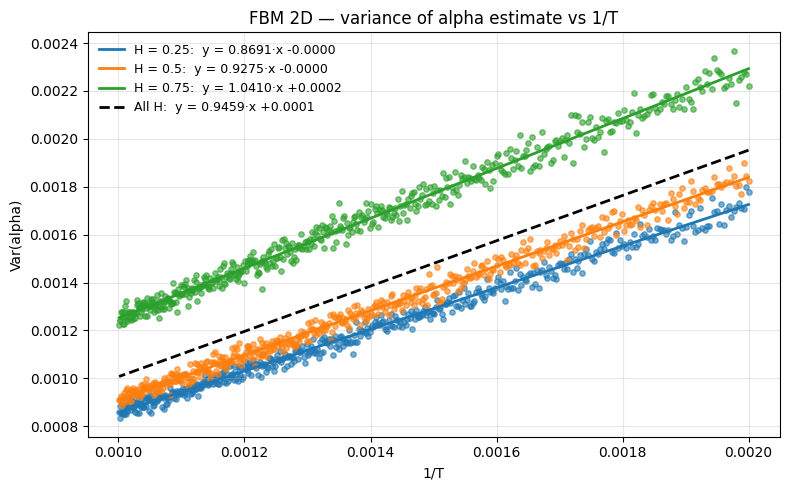

H = 0.25:  slope = 0.8691,  intercept = -0.0000
H = 0.50:  slope = 0.9275,  intercept = -0.0000
H = 0.75:  slope = 1.0410,  intercept = 0.0002
All H:    slope = 0.9459,  intercept = 0.0001


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from stochastic.processes.continuous import FractionalBrownianMotion
from sklearn.linear_model import LinearRegression          # ← новая регрессия

# ---------- генератор FBM-траекторий (N, T, 2) -------------------------------
def simulate_fbm_batch(T, n_traj, hurst):
    """
    FBM-траектории размера (n_traj, T, 2) с показателем Херста hurst.
    """
    T_int = int(T)
    trajs = np.empty((n_traj, T_int, 2), dtype=np.float64)

    for i in range(n_traj):
        fbm_x = FractionalBrownianMotion(hurst=hurst, t=T_int - 1)
        fbm_y = FractionalBrownianMotion(hurst=hurst, t=T_int - 1)

        # sample(T_int - 1) → T точек (0 … T-1)
        trajs[i, :, 0] = fbm_x.sample(T_int - 1)   # X
        trajs[i, :, 1] = fbm_y.sample(T_int - 1)   # Y

    return trajs



def draw_plot():
    # Parameters -------------------------------------------------------------
    H_values = [0.25, 0.50, 0.75]
    colours  = ['tab:blue', 'tab:orange', 'tab:green']
    n_traj   = 5000
    T_values = np.arange(500, 1000)          # trajectory lengths
    inv_T    = 1.0 / T_values             # x-axis: 1/T

    msd_tool = ta_msd()                   # your TA-MSD analyser

    # Containers
    var_dict   = {}       # Var(alpha) for each H
    param_dict = {}       # (slope, intercept) for each H

    # --- individual regressions -------------------------------------------
    for H in H_values:
        variances = np.empty_like(inv_T)
        for k, T in enumerate(T_values):
            trajs   = simulate_fbm_batch(T, n_traj, H)   # shape (N, T, 2)
            alphas  = msd_tool.get_exponent(trajs)       # shape (N,)
            variances[k] = np.var(alphas, ddof=1)        # Var(alpha)

        model = LinearRegression()                       # intercept=True
        model.fit(inv_T.reshape(-1, 1), variances)

        var_dict[H]   = variances.copy()
        param_dict[H] = (model.coef_[0], model.intercept_)

    # --- joint regression (all H together) ---------------------------------
    all_x = np.tile(inv_T, len(H_values)).reshape(-1, 1)
    all_y = np.concatenate([var_dict[h] for h in H_values])
    joint_model = LinearRegression().fit(all_x, all_y)
    joint_slope  = joint_model.coef_[0]
    joint_inter  = joint_model.intercept_

    # --- plotting ----------------------------------------------------------
    plt.figure(figsize=(8, 5))

    for H, colour in zip(H_values, colours):
        slope, inter = param_dict[H]
        plt.scatter(inv_T, var_dict[H], s=15, alpha=0.6, color=colour)
        plt.plot(inv_T, slope * inv_T + inter,
                 color=colour, lw=2,
                 label=f'H = {H}:  y = {slope:.4f}·x {inter:+.4f}')

    # joint line (black dashed)
    plt.plot(inv_T, joint_slope * inv_T + joint_inter,
             'k--', lw=2,
             label=f'All H:  y = {joint_slope:.4f}·x {joint_inter:+.4f}')

    plt.xlabel('1/T')
    plt.ylabel('Var(alpha)')
    plt.title('FBM 2D — variance of alpha estimate vs 1/T')
    plt.legend(frameon=False, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- console summary ---------------------------------------------------
    for H in H_values:
        slope, inter = param_dict[H]
        print(f'H = {H:.2f}:  slope = {slope:.4f},  intercept = {inter:.4f}')
    print(f'All H:    slope = {joint_slope:.4f},  intercept = {joint_inter:.4f}')

draw_plot()